<a href="https://colab.research.google.com/github/vitorsanp/dsprojects/blob/SandboxProjects/Project_Air_Accident_Severity_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Instant Air Accident Severity Classification

#0. Introdução

<strong><h4>Contexto</h4></strong>
<h5>Por muitos anos, os aviões foram considerados o segundo meio de transporte mais seguro do mundo - perdendo apenas para os elevadores. Viajando grandes distâncias em curto espaço de tempo, essas aeronaves trouxeram várias vantagens para o mundo, tanto em aplicações comerciais como regulares. Infelizmente, como qualquer meio de transporte, as aeronaves têm sua própria contagem de tragédias. Essa tragédia trouxe de volta discussões e polêmicas sobre a segurança das aeronaves e a capacidade humana durante as ocorrências aeronáuticas.</h5>

<strong><h4>Tema: Classificação do tipo de ocorrência de aeronaves, com base nos atributos de aeronave e vôo (CENIPA)</h4></strong>
<h5>Arquivos de dados:</h5>
<ul>
 <li>Ocorrência dos casos (2010-2019)</li>
 <li>Detalhes das aeronaves (2010-2019)</li>
</ul>
<h6>Links:</h6>
<ul>
 <li><a href="https://www.kaggle.com/paulovasconcellos/aeronautics-accidents-in-brazil">https://www.kaggle.com/paulovasconcellos/aeronautics-accidents-in-brazil</a>
 <li><a href="https://www2.fab.mil.br/cenipa/">https://www2.fab.mil.br/cenipa/</a>
</li><li><a href="https://dados.gov.br/dataset/ocorrencias-aeronauticas-da-aviacao-civil-brasileir">https://dados.gov.br/dataset/ocorrencias-aeronauticas-da-aviacao-civil-brasileir</a></li>
</ul>



# 1. Inicialização


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# importação das bibliotecas

import pandas                  as pd
import numpy                   as np
import matplotlib.pyplot       as plt
import warnings
import os
import seaborn as sns
import datetime
import plotly.graph_objects as go

warnings.filterwarnings("ignore")

In [ ]:
## Leitura dos arquivos de dados

aeronave = pd.read_csv('/content/drive/My Drive/Colab datasets/Final/aeronave.csv',sep=';',encoding='latin-1', index_col= 0)
ocorrencia = pd.read_csv('/content/drive/My Drive/Colab datasets/Final/ocorrencia.csv',sep=';',encoding='latin-1', index_col= 0)
#fator = pd.read_csv('/content/drive/My Drive/Colab datasets/Final/fator_contribuinte.csv',sep=';',encoding='latin-1', index_col= 0)

print('Leitura completa')

Leitura completa


In [ ]:
## Cópia de segurança do dado bruto

aeronave_ = aeronave.copy()
ocorrencia_ = ocorrencia.copy()
#fator_ = fator.copy()

In [ ]:
## Organizaçao indices

aeronave_.index.name = 'cod'
ocorrencia_.index.name = 'cod'

In [ ]:
## Merge de tabelas para fonte única

dataset = ocorrencia_.merge(aeronave_,how='left', on='cod')

#2. Limpeza

In [ ]:
## Limpeza inicial de atributos identificadores ou não uteis no primeiro momento

coldrop = ['codigo_ocorrencia1','codigo_ocorrencia2','codigo_ocorrencia3','codigo_ocorrencia4','investigacao_aeronave_liberada','investigacao_status','divulgacao_relatorio_numero','divulgacao_relatorio_publicado','total_recomendacoes','divulgacao_dia_publicacao',
           'aeronave_fatalidades_total','aeronave_matricula','cod','aeronave_nivel_dano']

dataset = dataset.reset_index().drop(coldrop ,axis=1)

NameError: ignored

In [ ]:
# Remove linhas duplicadas por conta do join
dataset = dataset.drop_duplicates()

In [ ]:
# Adequação da variavel de data e hora
dataset['ocorrencia_dia'] = pd.to_datetime(dataset['ocorrencia_dia'], errors='coerce')
#dataset['ocorrencia_hora'] = pd.to_datetime(dataset['ocorrencia_hora'], errors='coerce', format='H%:M%')

In [ ]:
# Adequação da variavel preditiva
dataset['ocorrencia_classificacao'] = dataset['ocorrencia_classificacao'].replace('INCIDENTE GRAVE','INCIDENTE')

In [ ]:
# Correção do campo lat/long
dataset['ocorrencia_latitude'] = dataset['ocorrencia_latitude'].apply(pd.to_numeric, downcast='float', errors='coerce')
dataset['ocorrencia_longitude'] = dataset['ocorrencia_longitude'].apply(pd.to_numeric, downcast='float', errors='coerce')

dataset['ocorrencia_latitude'] = dataset['ocorrencia_latitude'].fillna(0)
dataset['ocorrencia_longitude'] = dataset['ocorrencia_longitude'].fillna(0)

In [ ]:
# Correção assentos zero ou nulos
dataset['aeronave_assentos'] = dataset['aeronave_assentos'].replace(0, np.nan)
dataset['aeronave_assentos'] = dataset.groupby('aeronave_modelo')['aeronave_assentos'].transform(lambda x: x.fillna(x.max()))

# Correção ano fabricação zero ou nulos
dataset['aeronave_ano_fabricacao'] = dataset['aeronave_ano_fabricacao'].replace(0, np.nan)
dataset['aeronave_ano_fabricacao'] = dataset.groupby('aeronave_modelo')['aeronave_ano_fabricacao'].transform(lambda x: x.fillna(x.max()))

In [ ]:
# Criar campo dia da semana

dataset['dia_semana'] = dataset['ocorrencia_dia'].dt.weekday
dataset['hora'] = dataset['ocorrencia_hora'].str.slice(start=0, stop=2)

In [ ]:
# Drop NAs onde não foi possível encontrar o valor correto de assentos, ano de fabricação e hora
dataset = dataset[(dataset['aeronave_ano_fabricacao'].notna()) & (dataset['aeronave_assentos'].notna()) & (dataset['ocorrencia_hora'].notna())]

In [ ]:
#dataset['aeronave_modelo'][dataset['aeronave_ano_fabricacao'].isnull()].unique()
dataset.isnull().sum()

#3. Análise Exploratória

In [ ]:
print('Shape:', dataset.shape, ' Size:', dataset.size)
dataset.describe()

Shape: (5174, 32)  Size: 165568


,ocorrencia_latitude,ocorrencia_longitude,total_aeronaves_envolvidas,aeronave_pmd,aeronave_pmd_categoria,aeronave_assentos,aeronave_ano_fabricacao,dia_semana
count,5174.000000,5174.000000,5174.000000,5174.000000,5174.000000,5174.000000,5174.000000,5174.000000
mean,-8.072654,-23.232304,1.022806,14437.966950,14437.966950,28.936220,1995.286819,3.039428
std,17.277255,50.249084,0.156877,31857.473357,31857.473357,55.686328,112.397105,1.960067
min,-297.024994,-1000.677490,1.000000,0.000000,0.000000,1.000000,1936.000000,0.000000
25%,-16.722709,-47.776669,1.000000,1200.000000,1200.000000,2.000000,1980.000000,1.000000
50%,0.000000,0.000000,1.000000,2073.000000,2073.000000,6.000000,1996.000000,3.000000
75%,0.000000,0.000000,1.000000,5692.500000,5692.500000,11.000000,2008.000000,5.000000
max,55.582222,487.575012,3.000000,346544.000000,346544.000000,384.000000,9999.000000,6.000000


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5174 entries, 0 to 5306
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   ocorrencia_classificacao     5174 non-null   object        
 1   ocorrencia_latitude          5174 non-null   float64       
 2   ocorrencia_longitude         5174 non-null   float64       
 3   ocorrencia_cidade            5174 non-null   object        
 4   ocorrencia_uf                5174 non-null   object        
 5   ocorrencia_pais              5174 non-null   object        
 6   ocorrencia_aerodromo         5174 non-null   object        
 7   ocorrencia_dia               5174 non-null   datetime64[ns]
 8   ocorrencia_hora              5174 non-null   object        
 9   total_aeronaves_envolvidas   5174 non-null   int64         
 10  ocorrencia_saida_pista       5174 non-null   object        
 11  aeronave_operador_categoria  5174 non-null 

Total: 5174
INCIDENTE: 3513
ACIDENTE: 1661


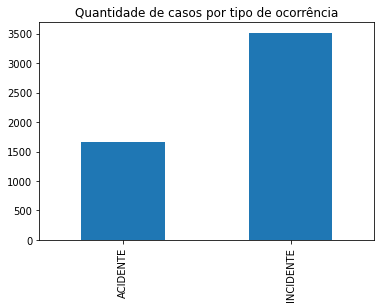

In [ ]:
dataset.reset_index().groupby('ocorrencia_classificacao', as_index=False ).agg({'index':'count'}).plot(kind='bar', x = 'ocorrencia_classificacao', legend = False, title ="Quantidade de casos por tipo de ocorrência")

print('Total: ' + str(dataset['ocorrencia_classificacao'].count()))
print('INCIDENTE: ' +str(dataset['ocorrencia_classificacao'][dataset['ocorrencia_classificacao'] == 'INCIDENTE'].count()))
print('ACIDENTE: ' +str(dataset['ocorrencia_classificacao'][dataset['ocorrencia_classificacao'] == 'ACIDENTE'].count()))
plt.xlabel("")
plt.show()

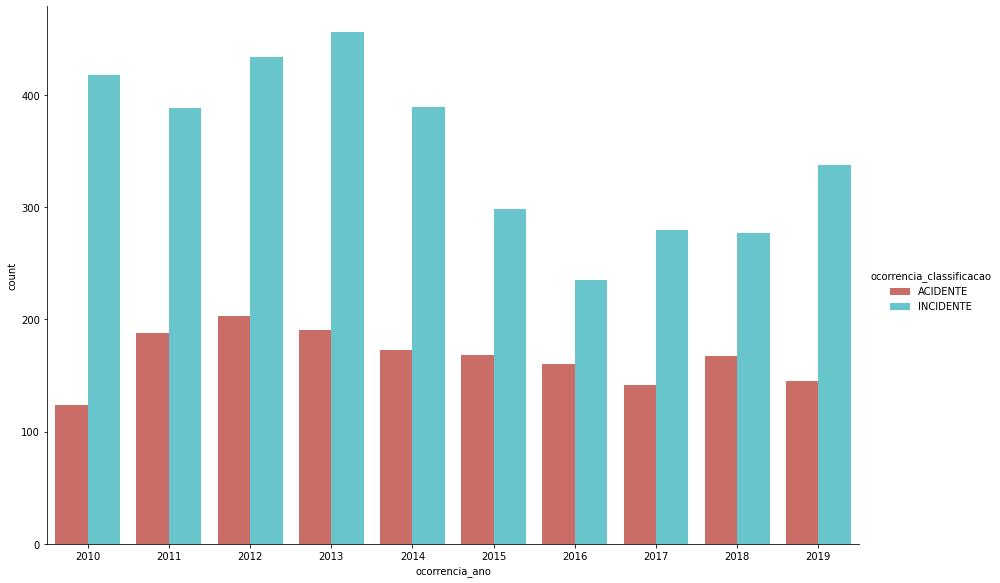

In [ ]:
#Função para extrair apenas o ano do campo "date"
def valid_year(date):
    ocorrencia_dia = str(date)
    try:
        ts = pd.to_datetime(date)
        return int(ts.year)
    except:
        return int(1900)

dataset["ocorrencia_ano"] = dataset["ocorrencia_dia"].apply(valid_year)
planting_date = sns.catplot(x="ocorrencia_ano", data=dataset[dataset["ocorrencia_ano"]>1900], kind="count",palette="hls", size=8, aspect=1.5, hue = 'ocorrencia_classificacao')
planting_date.set_xticklabels(step=1)
plt.show()

In [ ]:
#
print('Tipos de operações')
print('********************')
for ocorr in dataset['aeronave_tipo_operacao'].unique():
    
    print(ocorr + ' :' +
          str(dataset['aeronave_tipo_operacao'][
              dataset['aeronave_tipo_operacao'] == ocorr
              ].count()
             )
         )

Tipos de operações
********************
PRIVADA :1668
REGULAR :981
AGRÍCOLA :407
EXPERIMENTAL :258
TÁXI AÉREO :699
INSTRUÇÃO :714
ESPECIALIZADA :67
POLICIAL :135
NÃO REGULAR :50
*** :195


In [ ]:
print('Tipo de Segmento da Aeronave')
print('********************')
for dano in dataset['aeronave_registro_segmento'].unique():
    
    print(dano + ' :' +
          str(dataset['aeronave_registro_segmento'][
              dataset['aeronave_registro_segmento'] == dano
              ].count()
             )
         )

Tipo de Segmento da Aeronave
********************
PARTICULAR :1593
REGULAR :1028
AGRÍCOLA :295
EXPERIMENTAL :406
TÁXI AÉREO :716
INSTRUÇÃO :757
ESPECIALIZADA :99
ADMINISTRAÇÃO DIRETA :167
ADMINISTRAÇÃO INDIRETA :8
*** :53
NÃO REGULAR :20
MÚLTIPLA :30
HISTÓRICA :2


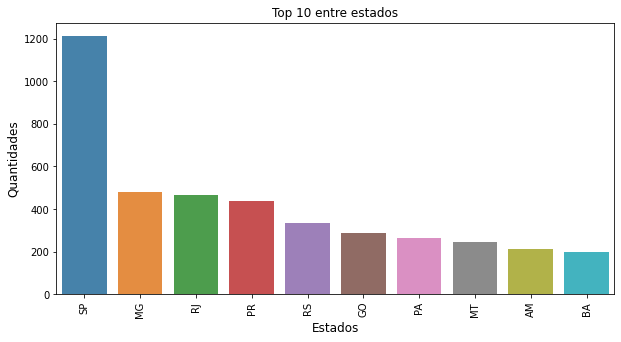

In [ ]:
# Exploração por estados

dataset_count_uf  = dataset.ocorrencia_uf.value_counts()
dataset_count_uf = dataset_count_uf[:10,]
plt.figure(figsize=(10,5))
sns.barplot(dataset_count_uf.index, dataset_count_uf.values, alpha=0.9)
plt.title('Top 10 entre estados')
plt.ylabel('Quantidades', fontsize=12)
plt.xlabel('Estados', fontsize=12)
plt.xticks(rotation=90)
plt.show()

In [ ]:
#Evolução entre os anos

year_freq_dict = { }
year_freq_dict['all'] = {}

for s in dataset['ocorrencia_uf'].unique():
    year_freq_dict[s] = {}

for occ in dataset['ocorrencia_ano'].unique():
    
    year_freq_dict['all'][occ] = dataset['ocorrencia_ano'][
                                    dataset['ocorrencia_ano'] == occ
                                    ].count()

    for s in dataset['ocorrencia_uf'].unique():
        
        year_freq_dict[s][occ] = dataset['ocorrencia_ano'][
                                        (dataset['ocorrencia_ano'] == occ) &
                                        (dataset['ocorrencia_uf'] == s)
                                        ].count()


year_freq = pd.DataFrame(year_freq_dict)

year_freq

,all,BA,MG,PR,PA,MA,SP,GO,RJ,AM,SC,MT,DF,TO,RS,AC,RR,MS,PE,CE,ES,AP,AL,RO,SE,PB,PI,RN,***
2010,542,33,51,43,30,12,102,27,62,19,22,27,23,9,24,7,5,6,12,6,5,2,3,1,5,3,2,1,0
2011,576,20,43,41,24,4,132,45,76,30,12,26,17,4,32,7,7,15,11,7,9,0,2,2,4,1,3,2,0
2012,637,28,67,42,29,7,148,37,69,27,13,31,15,7,37,10,7,16,10,8,12,3,3,1,1,3,4,2,0
2013,647,20,56,56,25,6,157,35,76,31,18,29,16,3,39,3,3,21,11,7,12,1,1,7,2,5,5,1,1
2014,562,22,50,49,42,7,132,23,48,30,11,22,17,5,39,9,5,11,9,13,3,0,1,1,4,2,6,1,0
2015,466,15,52,43,19,9,121,25,29,18,22,21,9,5,29,0,4,9,6,7,4,0,2,5,2,1,5,3,1
2016,395,14,27,47,18,3,101,16,20,10,20,21,13,4,32,2,5,11,8,10,5,1,0,2,0,2,2,1,0
2017,422,15,39,47,30,3,94,22,27,11,20,22,6,5,36,2,7,11,4,5,7,0,2,3,1,1,1,1,0
2018,444,17,47,28,24,8,112,28,29,13,11,22,3,3,37,4,0,11,7,7,7,1,13,5,1,2,4,0,0
2019,483,15,48,44,22,6,115,28,31,23,18,27,10,0,28,8,3,17,12,6,5,1,3,3,2,3,3,1,1


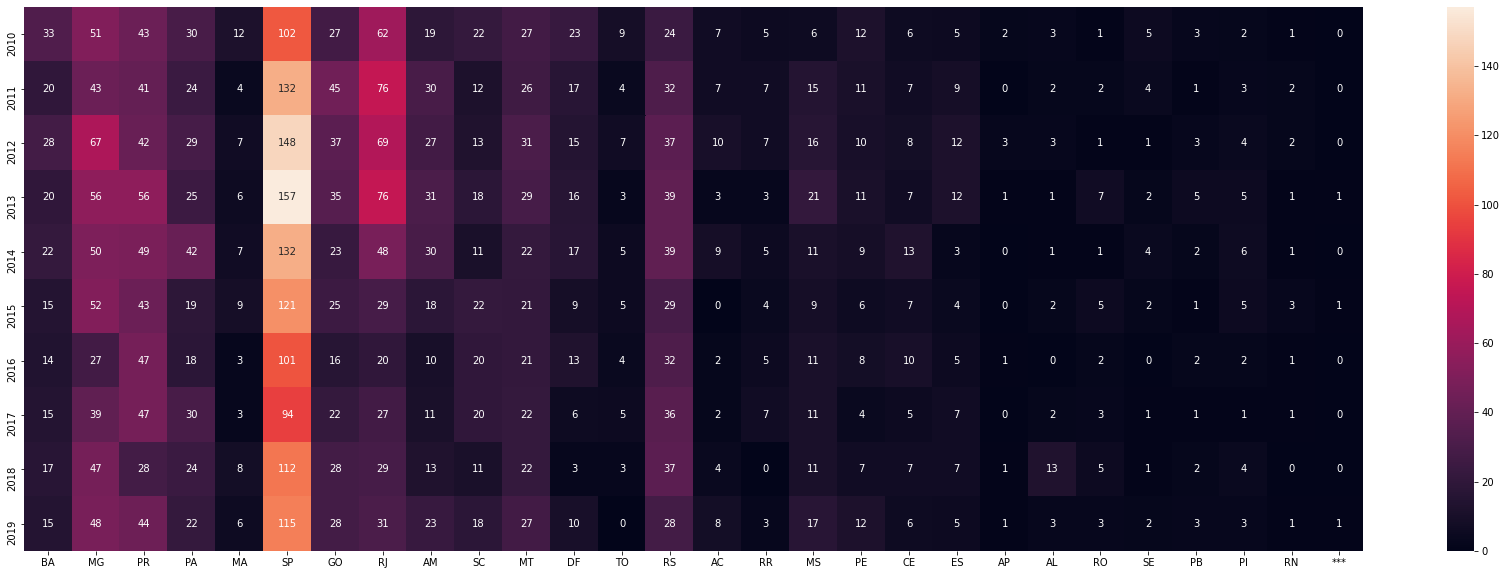

In [ ]:
fig, ax = plt.subplots(figsize=(30,10))
sns.heatmap(year_freq.loc[:, year_freq.columns != 'all'], annot=True, fmt= 'd')
fig.show()

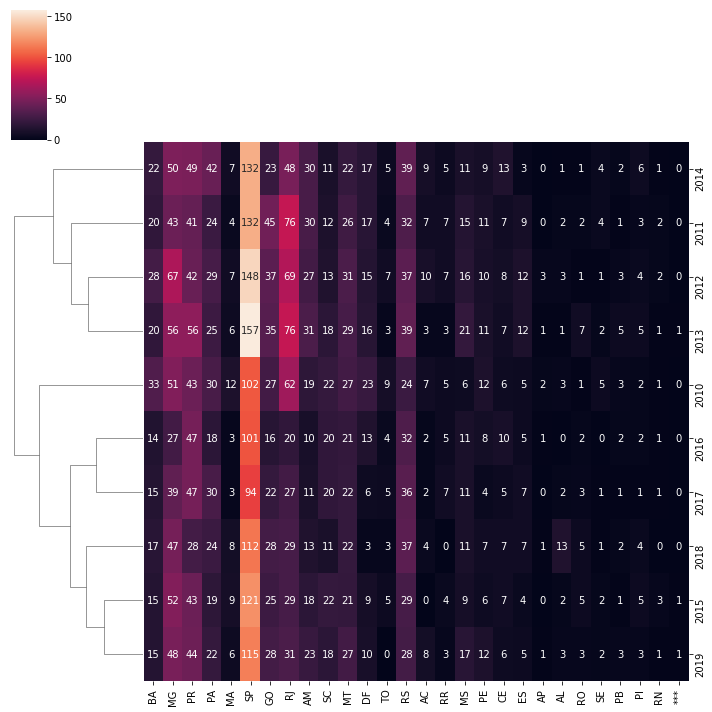

In [ ]:
sns.clustermap(year_freq.loc[:, year_freq.columns != 'all'],annot=True, fmt= 'd',col_cluster=False)
fig.show()

In [ ]:
# Mapeamento dos acidentes

fig = go.Figure(data=go.Scattergeo(
        lon = dataset[dataset['ocorrencia_classificacao']=='ACIDENTE']['ocorrencia_longitude'],
        lat = dataset[dataset['ocorrencia_classificacao']=='ACIDENTE']['ocorrencia_latitude'],
        text = dataset[dataset['ocorrencia_classificacao']=='ACIDENTE']['ocorrencia_classificacao'],
        marker_color='Blue',
        mode = 'markers'
        ))

fig.update_layout(
        title = '',
        geo_scope='south america',
        mapbox_style="dark"
    )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})


In [ ]:
# Mapeamento dos incidentes

fig = go.Figure(data=go.Scattergeo(
        lon = dataset[dataset['ocorrencia_classificacao']=='INCIDENTE']['ocorrencia_longitude'],
        lat = dataset[dataset['ocorrencia_classificacao']=='INCIDENTE']['ocorrencia_latitude'],
        text = dataset[dataset['ocorrencia_classificacao']=='INCIDENTE']['ocorrencia_classificacao'],
        marker_color='Green',
        mode = 'markers'
        ))

fig.update_layout(
        title = '',
        geo_scope='south america'
    )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

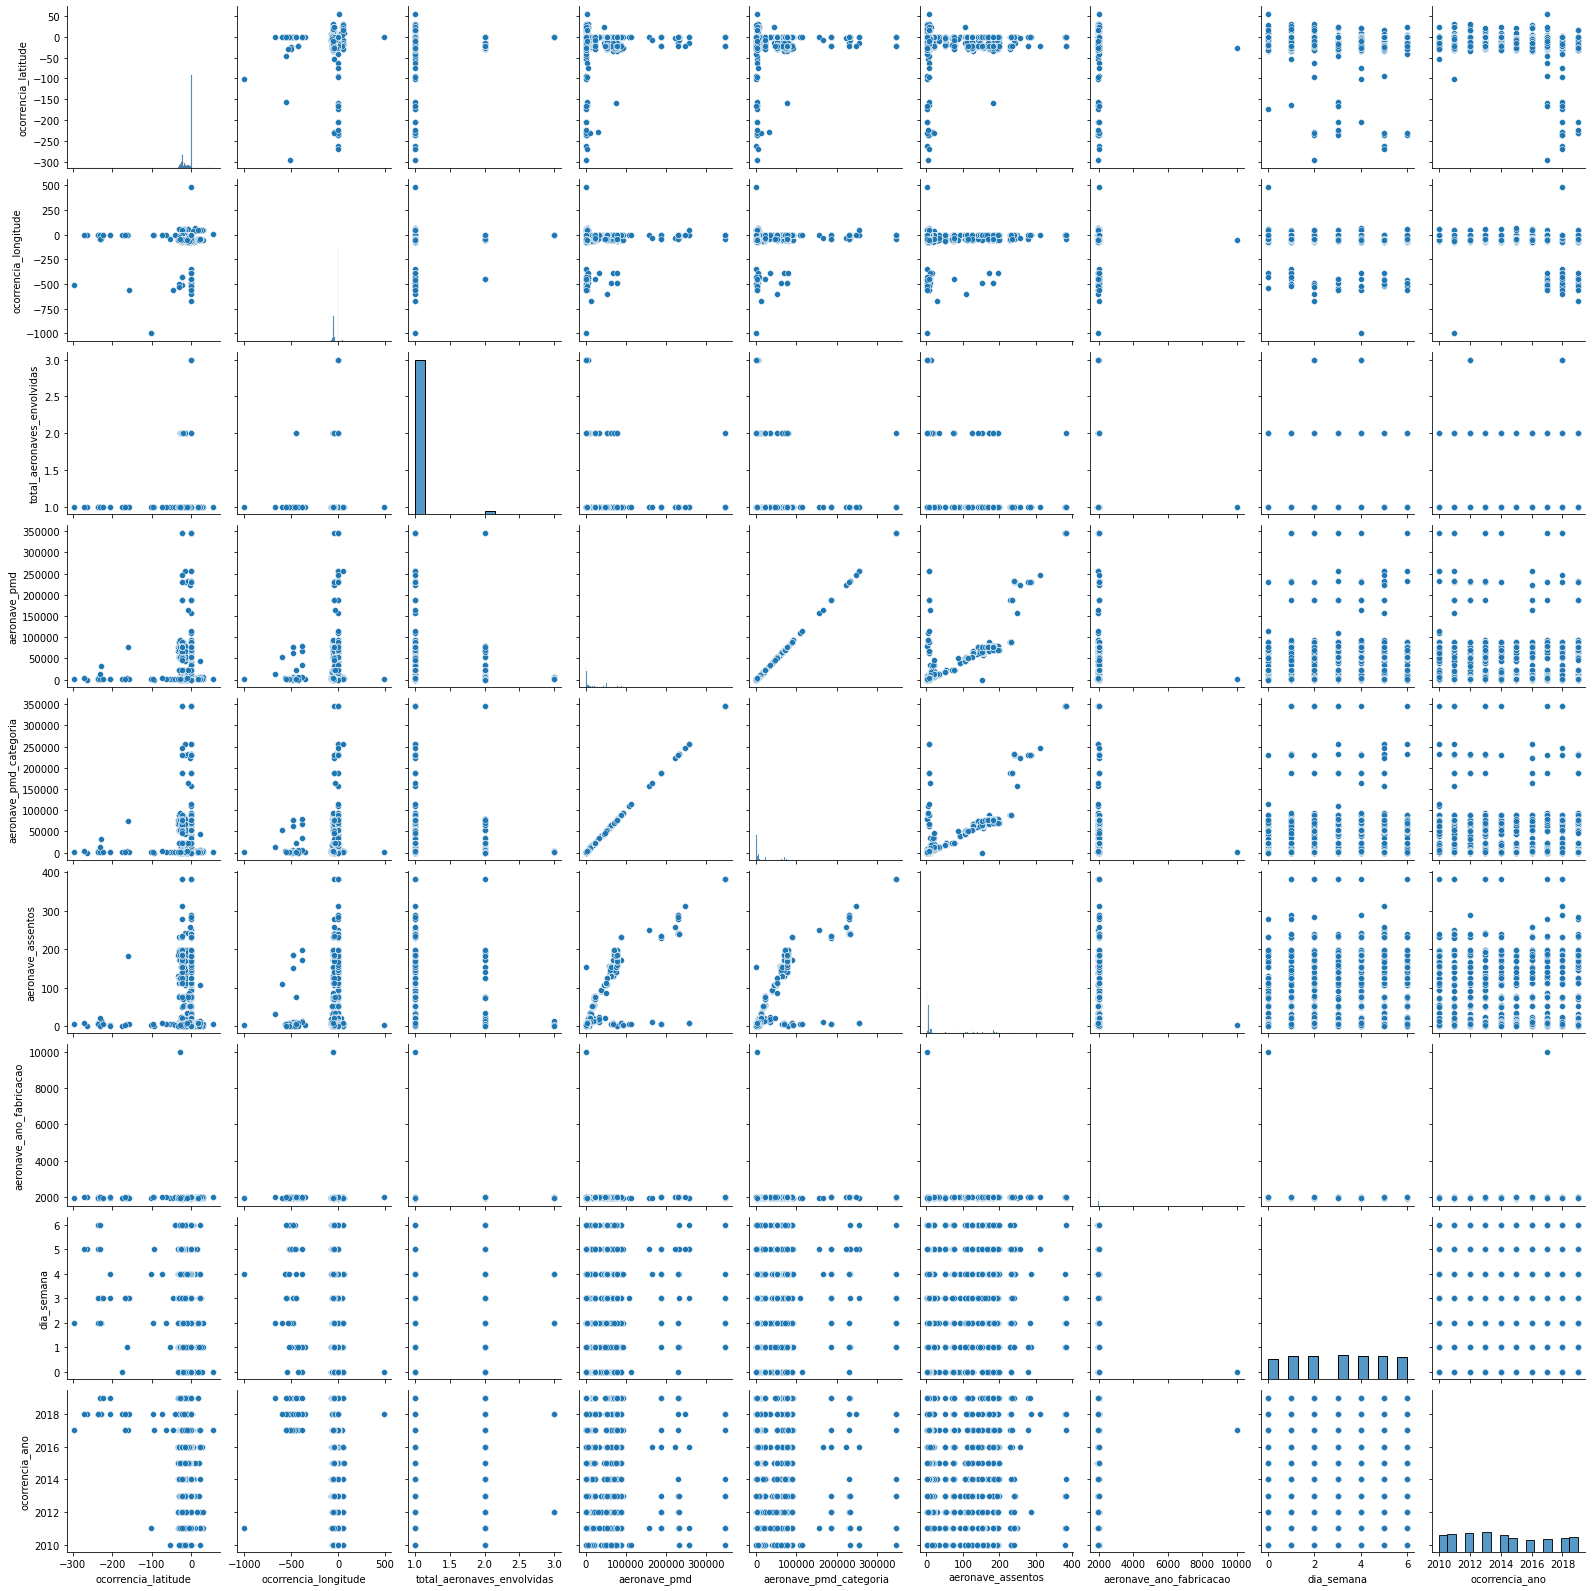

In [ ]:
# Correlação de campos
sns.pairplot(dataset)

#4. Transformação


In [ ]:
# Carregamento de bibliotecas para organização e transformação dos dados
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split

In [ ]:
# Remoção colunas de data, hora e país

dataset0 = dataset.copy()
dataset0 = dataset0.drop(columns=['ocorrencia_dia','ocorrencia_hora','ocorrencia_ano','ocorrencia_pais'])

In [ ]:
# Separação da variavel preditiva

X = dataset0.drop(columns=['ocorrencia_classificacao'])
y = dataset0['ocorrencia_classificacao']

In [ ]:
# Label encode

df_categorical = X.select_dtypes(exclude='number')

label_encoders = {}
for col in df_categorical:
        le = LabelEncoder()
        le.fit(X[col])
        X[col] = le.transform(X[col])
        label_encoders[col] = le

In [ ]:
#Scaler

scaler = StandardScaler()
scaler.fit(X)
X_matrix = scaler.transform(X)
temp = X.index
X = pd.DataFrame(X_matrix,columns=X.columns)
X.index = temp
X.describe()

,ocorrencia_latitude,ocorrencia_longitude,ocorrencia_cidade,ocorrencia_uf,ocorrencia_aerodromo,total_aeronaves_envolvidas,ocorrencia_saida_pista,aeronave_operador_categoria,aeronave_tipo_veiculo,aeronave_fabricante,aeronave_modelo,aeronave_tipo_icao,aeronave_motor_tipo,aeronave_motor_quantidade,aeronave_pmd,aeronave_pmd_categoria,aeronave_assentos,aeronave_ano_fabricacao,aeronave_pais_fabricante,aeronave_pais_registro,aeronave_registro_categoria,aeronave_registro_segmento,aeronave_voo_origem,aeronave_voo_destino,aeronave_fase_operacao,aeronave_tipo_operacao,dia_semana,hora
count,5.174000e+03,5.174000e+03,5.174000e+03,5.174000e+03,5.174000e+03,5.174000e+03,5.174000e+03,5.174000e+03,5.174000e+03,5.174000e+03,5.174000e+03,5.174000e+03,5.174000e+03,5.174000e+03,5.174000e+03,5.174000e+03,5.174000e+03,5.174000e+03,5.174000e+03,5.174000e+03,5.174000e+03,5.174000e+03,5.174000e+03,5.174000e+03,5.174000e+03,5.174000e+03,5.174000e+03,5.174000e+03
mean,5.265003e-16,-2.706271e-15,1.014843e-16,-1.546030e-16,1.033834e-15,8.819128e-16,1.552789e-15,4.428532e-15,-1.159898e-15,6.296557e-16,-3.074464e-16,-8.810545e-17,-7.087489e-16,8.842302e-16,1.412133e-16,1.412133e-16,5.316153e-16,-4.322767e-16,3.587035e-16,3.587035e-16,-1.159898e-15,1.642879e-15,2.779635e-16,-1.668768e-16,3.602753e-17,8.321094e-16,8.926416e-17,-1.511483e-16
std,1.000097e+00,1.000097e+00,1.000097e+00,1.000097e+00,1.000097e+00,1.000097e+00,1.000097e+00,1.000097e+00,1.000097e+00,1.000097e+00,1.000097e+00,1.000097e+00,1.000097e+00,1.000097e+00,1.000097e+00,1.000097e+00,1.000097e+00,1.000097e+00,1.000097e+00,1.000097e+00,1.000097e+00,1.000097e+00,1.000097e+00,1.000097e+00,1.000097e+00,1.000097e+00,1.000097e+00,1.000097e+00
min,-1.672605e+01,-1.945388e+01,-1.752318e+00,-2.211906e+00,-6.690110e-01,-1.453917e-01,-3.093900e-01,-2.085176e+00,-1.471896e+00,-1.201959e+00,-1.673536e+00,-1.541945e+00,-1.817580e+00,-2.258127e+00,-4.532488e-01,-4.532488e-01,-5.017196e-01,-5.275274e-01,-3.728280e+00,-3.728280e+00,-1.471896e+00,-2.808298e+00,-2.084430e+00,-2.116111e+00,-1.536250e+00,-2.294699e+00,-1.550825e+00,-2.803063e+00
25%,-5.007098e-01,-4.885012e-01,-9.038977e-01,-7.600231e-01,-6.511072e-01,-1.453917e-01,-3.093900e-01,-7.795122e-01,-3.979164e-01,-6.987999e-01,-7.687677e-01,-9.393150e-01,-2.604712e-01,-8.513181e-01,-4.155774e-01,-4.155774e-01,-4.837601e-01,-1.360204e-01,-8.909233e-02,-8.909233e-02,-3.979164e-01,-5.508140e-01,7.693439e-02,9.531107e-02,-8.016913e-01,-7.649984e-01,-1.040589e+00,-5.257829e-01
50%,4.672869e-01,4.623875e-01,5.340201e-02,1.639025e-01,-3.915010e-01,-1.453917e-01,-3.093900e-01,5.261518e-01,-3.979164e-01,-4.553356e-01,-3.542910e-02,3.416443e-02,-2.604712e-01,5.554912e-01,-3.881715e-01,-3.881715e-01,-4.119222e-01,6.345806e-03,-8.909233e-02,-8.909233e-02,-3.979164e-01,4.166789e-01,7.693439e-02,9.531107e-02,-6.967543e-01,3.822774e-01,-2.011754e-02,4.353710e-02
75%,4.672869e-01,4.623875e-01,9.076852e-01,9.558388e-01,1.903748e-01,-1.453917e-01,-3.093900e-01,7.872846e-01,-3.979164e-01,1.216452e+00,4.924659e-01,1.039737e+00,-2.604712e-01,5.554912e-01,-2.745451e-01,-2.745451e-01,-3.221249e-01,1.131204e-01,-8.909233e-02,-8.909233e-02,-3.979164e-01,7.391766e-01,7.693439e-02,9.531107e-02,9.822382e-01,7.647027e-01,1.000354e+00,8.026304e-01
max,3.684673e+00,1.016649e+01,1.688265e+00,1.351807e+00,3.636870e+00,1.260472e+01,3.232167e+00,1.048417e+00,3.361014e+00,2.239002e+00,1.972749e+00,1.467640e+00,2.075192e+00,4.775919e+00,1.042575e+01,1.042575e+01,6.376755e+00,7.121613e+01,1.931991e+01,1.931991e+01,3.361014e+00,1.061674e+00,2.317549e+00,2.458200e+00,1.716797e+00,1.147128e+00,1.510590e+00,1.561724e+00


In [ ]:
#Separação de treino e teste

seed = 7777
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed)

#5. Modelagem

In [ ]:
#Importação das bibliotecas de modelagem

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve

##5.1 Decision Tree


In [ ]:
# Decision Tree
d_tree = DecisionTreeClassifier(criterion='gini',
                               max_depth=2,
                               random_state=seed)

d_tree.fit(X_train, y_train) 

y_pred0 = d_tree.predict(X_test)

cm = confusion_matrix(y_pred0, y_test)
print(cm)
    
accuracy = accuracy_score(y_pred0, y_test)
print(accuracy)

print(classification_report(y_pred0,y_test))

[[183  58]
 [149 645]]
0.8
              precision    recall  f1-score   support

    ACIDENTE       0.55      0.76      0.64       241
   INCIDENTE       0.92      0.81      0.86       794

    accuracy                           0.80      1035
   macro avg       0.73      0.79      0.75      1035
weighted avg       0.83      0.80      0.81      1035



## 5.2 Random Forest - primeira execução

In [ ]:
# Random forest
clf = RandomForestClassifier(n_estimators= 300, random_state=77)

In [ ]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(y_pred)

['ACIDENTE' 'ACIDENTE' 'ACIDENTE' ... 'INCIDENTE' 'ACIDENTE' 'INCIDENTE']


In [ ]:
cm = confusion_matrix(y_pred, y_test)
print(cm)
    
accuracy = accuracy_score(y_pred, y_test)
print(accuracy)

print(classification_report(y_pred,y_test))

[[253  63]
 [ 79 640]]
0.8628019323671497
              precision    recall  f1-score   support

    ACIDENTE       0.76      0.80      0.78       316
   INCIDENTE       0.91      0.89      0.90       719

    accuracy                           0.86      1035
   macro avg       0.84      0.85      0.84      1035
weighted avg       0.87      0.86      0.86      1035



#6. Balanceamento de classe

In [ ]:
dataset1 = dataset0.copy()
dataset1['ocorrencia_classificacao'] = [1 if b=='INCIDENTE' else 0 for b in dataset1.ocorrencia_classificacao]
dataset1['ocorrencia_classificacao'].value_counts()

1    3513
0    1661
Name: ocorrencia_classificacao, dtype: int64

In [ ]:
# Utilização de Upsample para balanceamento de classes
from sklearn.utils import resample

# Separação de classe majoritaria e minoritaria
df_majority = dataset1[dataset1.ocorrencia_classificacao==1]
df_minority = dataset1[dataset1.ocorrencia_classificacao==0]

# Upsample na minoritaria
df_minority_upsampled = resample(df_minority,
                                 replace= True,
                                 n_samples= 3513,
                                 random_state= 777)
 
# Concatenação
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
df_upsampled.ocorrencia_classificacao.value_counts()

1    3513
0    3513
Name: ocorrencia_classificacao, dtype: int64

In [ ]:
y1 = df_upsampled.ocorrencia_classificacao
X1 = df_upsampled.drop('ocorrencia_classificacao', axis=1)

In [ ]:
# Label encode
df_categorical = X1.select_dtypes(exclude='number')

label_encoders = {}
for col in df_categorical:
        le = LabelEncoder()
        le.fit(X1[col])
        X1[col] = le.transform(X1[col])
        label_encoders[col] = le

In [ ]:
# Scaler

scaler = StandardScaler()
scaler.fit(X1)
X_matrix1 = scaler.transform(X1)
temp = X1.index
X1 = pd.DataFrame(X_matrix1,columns=X1.columns)
X1.index = temp
X1.describe()

,ocorrencia_latitude,ocorrencia_longitude,ocorrencia_cidade,ocorrencia_uf,ocorrencia_aerodromo,total_aeronaves_envolvidas,ocorrencia_saida_pista,aeronave_operador_categoria,aeronave_tipo_veiculo,aeronave_fabricante,aeronave_modelo,aeronave_tipo_icao,aeronave_motor_tipo,aeronave_motor_quantidade,aeronave_pmd,aeronave_pmd_categoria,aeronave_assentos,aeronave_ano_fabricacao,aeronave_pais_fabricante,aeronave_pais_registro,aeronave_registro_categoria,aeronave_registro_segmento,aeronave_voo_origem,aeronave_voo_destino,aeronave_fase_operacao,aeronave_tipo_operacao,dia_semana,hora
count,7.026000e+03,7.026000e+03,7.026000e+03,7.026000e+03,7.026000e+03,7.026000e+03,7.026000e+03,7.026000e+03,7.026000e+03,7.026000e+03,7.026000e+03,7.026000e+03,7.026000e+03,7.026000e+03,7.026000e+03,7.026000e+03,7.026000e+03,7.026000e+03,7.026000e+03,7.026000e+03,7.026000e+03,7.026000e+03,7.026000e+03,7.026000e+03,7.026000e+03,7.026000e+03,7.026000e+03,7.026000e+03
mean,-6.724442e-15,1.060283e-14,-1.091893e-17,-1.491675e-17,-6.111915e-16,-2.454468e-15,8.583955e-15,4.471294e-15,-3.888435e-15,-5.388911e-16,-6.303747e-16,2.235900e-15,-2.595814e-15,3.153375e-16,-1.597293e-15,-1.597293e-15,8.848798e-15,-7.507950e-16,-1.751256e-16,-1.751256e-16,-3.888435e-15,-7.013873e-15,-1.218717e-15,2.287445e-16,-4.260121e-17,1.547318e-14,2.340222e-16,-1.196105e-16
std,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00,1.000071e+00
min,-1.588570e+01,-1.932652e+01,-1.728869e+00,-2.221361e+00,-6.457109e-01,-1.372691e-01,-3.329115e-01,-1.958579e+00,-1.410876e+00,-1.231178e+00,-1.722870e+00,-1.616237e+00,-1.938545e+00,-2.501835e+00,-3.952193e-01,-3.952193e-01,-4.345467e-01,-5.985424e-01,-3.674397e+00,-3.674397e+00,-1.410876e+00,-2.627176e+00,-2.088733e+00,-2.133489e+00,-1.556453e+00,-2.124005e+00,-1.563887e+00,-2.999235e+00
25%,-5.919268e-01,-4.298032e-01,-9.219260e-01,-7.582116e-01,-6.283313e-01,-1.372691e-01,-3.329115e-01,-6.688662e-01,-4.223131e-01,-7.387925e-01,-7.151831e-01,-8.001839e-01,-2.572442e-01,-1.014703e+00,-3.555484e-01,-3.555484e-01,-4.143816e-01,-1.544511e-01,-8.763555e-02,-8.763555e-02,-4.223131e-01,-4.253873e-01,-3.532593e-02,5.772924e-02,-7.996465e-01,-6.342861e-01,-1.053701e+00,-5.986169e-01
50%,5.207223e-01,5.478852e-01,6.001635e-02,1.728836e-01,-4.979839e-01,-1.372691e-01,-3.329115e-01,6.208462e-01,-4.223131e-01,-4.416637e-01,2.344482e-01,4.450289e-02,-2.572442e-01,4.724276e-01,-3.322496e-01,-3.322496e-01,-3.538861e-01,4.644969e-04,-8.763555e-02,-8.763555e-02,-4.223131e-01,5.182366e-01,6.959269e-02,8.948602e-02,-6.915313e-01,4.830031e-01,-3.332982e-02,1.537544e-03
75%,5.207223e-01,5.478852e-01,9.120347e-01,9.709653e-01,1.885120e-01,-1.372691e-01,-3.329115e-01,8.787887e-01,-4.223131e-01,1.162832e+00,6.823092e-01,9.750901e-01,-2.572442e-01,4.724276e-01,-2.524180e-01,-2.524180e-01,-2.933907e-01,1.450524e-01,-8.763555e-02,-8.763555e-02,-4.223131e-01,8.327778e-01,1.051901e-01,8.948602e-02,1.038313e+00,8.554328e-01,9.870418e-01,8.017435e-01
max,3.590852e+00,1.817055e+00,1.689811e+00,1.370006e+00,3.360297e+00,1.354292e+01,3.003802e+00,1.136731e+00,3.037657e+00,2.130623e+00,1.893193e+00,1.404592e+00,2.264706e+00,4.933821e+00,1.172798e+01,1.172798e+01,7.288708e+00,8.267375e+01,1.904176e+01,1.904176e+01,3.037657e+00,1.147319e+00,2.287872e+00,2.415671e+00,1.795119e+00,1.227862e+00,1.497228e+00,1.601949e+00


In [ ]:
# Separação treino teste
seed = 7777
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.3, stratify=y1, random_state=seed)

## 6.1 Random Forest - segunda execução

In [ ]:
# Random forest definição
clf1=RandomForestClassifier(n_estimators= 300, random_state=77)

In [ ]:
# Ajuste e predição
clf1.fit(X_train1, y_train1)
y_pred1 = clf1.predict(X_test1)

print(y_pred1)

[0 0 1 ... 0 0 0]


In [ ]:
#Score do modelo
cm = confusion_matrix(y_pred1, y_test1)
print(cm)
    
accuracy = accuracy_score(y_pred1, y_test1)
print(accuracy)

print(classification_report(y_pred1,y_test1))

[[1007  119]
 [  47  935]]
0.9212523719165086
              precision    recall  f1-score   support

           0       0.96      0.89      0.92      1126
           1       0.89      0.95      0.92       982

    accuracy                           0.92      2108
   macro avg       0.92      0.92      0.92      2108
weighted avg       0.92      0.92      0.92      2108



No Skill: ROC AUC=0.500
Decision Tree: ROC AUC=0.980


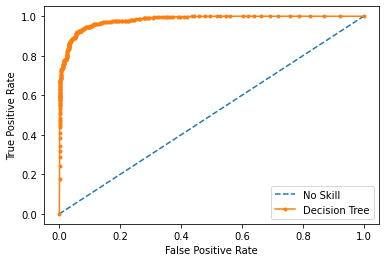

In [ ]:
# Plot da curva ROC

# Probabilidades
lr_probs = clf1.predict_proba(X_test1)
lr_probs = lr_probs[:, 1]

# No SKill
ns_probs = [0 for _ in range(len(y_test1))]

# Scores
ns_auc = roc_auc_score(y_test1, ns_probs)
lr_auc = roc_auc_score(y_test1, lr_probs)

# Resumo dos Scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Decision Tree: ROC AUC=%.3f' % (lr_auc))

# Curva ROC
ns_fpr, ns_tpr, _ = roc_curve(y_test1, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test1, lr_probs)

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Decision Tree')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# 7. Conclusão

<h4><strong>EDA</strong></h4>
<h6>Por se tratar de ocorrências, nós baseamos o estudo nas principais classificações relacionados a incidentes e acidentes.</h6>
<h6>Baseado nas análises exploratórias a primeira variável à ser validada foi o campo "classificação", onde é possível observar que 67% dos casos estão relacionados aos incidentes leves e incidentes graves. Deste modo, agrupamos os incidentes em apenas uma classificação para que fosse possível explorá-la e comparar com os acidentes de forma mais equilibrada.</h6>
<ul>
<li>Total: 5174
  <li>Incidente: 3513
  <li>Acidente: 1661
 </ul>
 </li>

<h6>Realizamos uma análise temporal e não identificamos uma variação de queda sazonal, apenas uma queda em 2016, que incialmente se dá a enteder que está relacionada à fatores externos, porém com baixa influência na série.</h6>

<h6>Com o agrupamento por estados é possível observar que a maior concentração está relacionada ao estado de São Paulo, porém ao relativizar o volume, o estado de SP não possui uma variação representativa. Os estados que se destacam mais são RJ, MG e PR.</h6>

<h6>É possível explorar baseado na visão de plots geográficos, mas vale reportar que existem algumas marções que estão longe do território brasileiro, destacando que as coordenadas geográficas não são 100% assertivas.</h6>

<h4><strong>Modelos preditivos</strong></h4>
<h6>Além de definir o campo "classificação"como a nossa variável preditiva, foi utilizada a técnica "StandardScaler" para a normalização dos dados. Além da remoção de algumas variáveis irrelevantes que poderiam impactar negativamente o nosso modelo.</h6>

<h6>Realizamos a primeira aplicação do modelo utilizando a árvore de decisão, porém a acuracidade de classicação inicial foi relativamente baixa. O que nos levou a rever as variáveis e alterar o modelo de classificação para Random Forest. </h6>

<h6>Durante a primeira execução do modelo de classificação utilizando Random Forest, observamos que as classes estavam desbalanceadas e, portanto, precisariam ser balanceadas. Neste caso, utilizamos a técnica de Upsample, que consiste em adequar a classe minoritária à classe majoritária, ou seja, equilibrar o número de casos entre as classes aumentando a que possuir o menor número de ocorrências. Após o balanceamento, tivemos um incremento na acuracidade, onde a classe que estava desbalanceada, no caso a classe "ACIDENTE", aumentou consideravelmente em precisão e recall. Já a classe "INCIDENTE" teve uma leve decaída em seu índice de precisão, porém um aumento em recall e f1-score. Além disso, a acuracidade do modelo passou de 0.86 para 0.92, sendo possível afirmar que a classificação possui alto nível de assertividade.</h6>

### **Decision Tree, primeiro modelo:**

####Matriz de confusão
#####VP = 183  FP = 58
#####FN = 149   VN = 645
#### Score de acuracidade = 0.8

              precision    recall  f1-score   support
    ACIDENTE       0.55      0.76      0.64       241
    INCIDENTE      0.92      0.81      0.86       794

    accuracy                           0.80      1035
    macro avg      0.73      0.79      0.75      1035
    weighted avg   0.83      0.80      0.81      1035


### **Random Forest, segundo modelo:**

####Matriz de confusão
#####VP = 253  FP = 63
#####FN = 79   VN = 640
#### Score de acuracidade = 0.8628

              precision    recall  f1-score   support
    ACIDENTE       0.76      0.80      0.78       316
    INCIDENTE      0.91      0.89      0.90       719

    accuracy                           0.86      1035
    macro avg      0.84      0.85      0.84      1035
    weighted avg   0.87      0.86      0.86      1035


### **Random Forest, com classe balanceada:**

####Matriz de confusão
#####VP = 1007 FP = 119
#####FN = 47   VN = 935
#### Score de acuracidade = 0.9212

              precision    recall  f1-score   support
    ACIDENTE       0.96      0.89      0.92      1126
    INCIDENTE      0.89      0.95      0.92       982

    accuracy                           0.92      2108
    macro avg      0.92      0.92      0.92      2108
    weighted avg   0.92      0.92      0.92      2108